**本章主要内容**  
探索transformer模型主要模块以及如何用PyTorch实现（也会提供TensorFlow指导版本），具体的行文脉络如下：
1. 首先关注构建attention 机制
2. 一点点增加使得encoder发挥作用的内容
3. 简单介绍下encoder和decoder模块结构的不同点
4. 最终将自己实现一个简单的transformer模型

# The Transformer Architecture



**encoder-decoder结构**  
* Encoder:  
    将输入的token序列转变为embedding向量，经常被称为hidden state或者context
* Decoder:  
    利用encoder的hidden state循环生成输出序列的token，每次生成一个token

如下图所示Encoder是上半部分，Decoder是下半部分，两者分别由几个模块组成
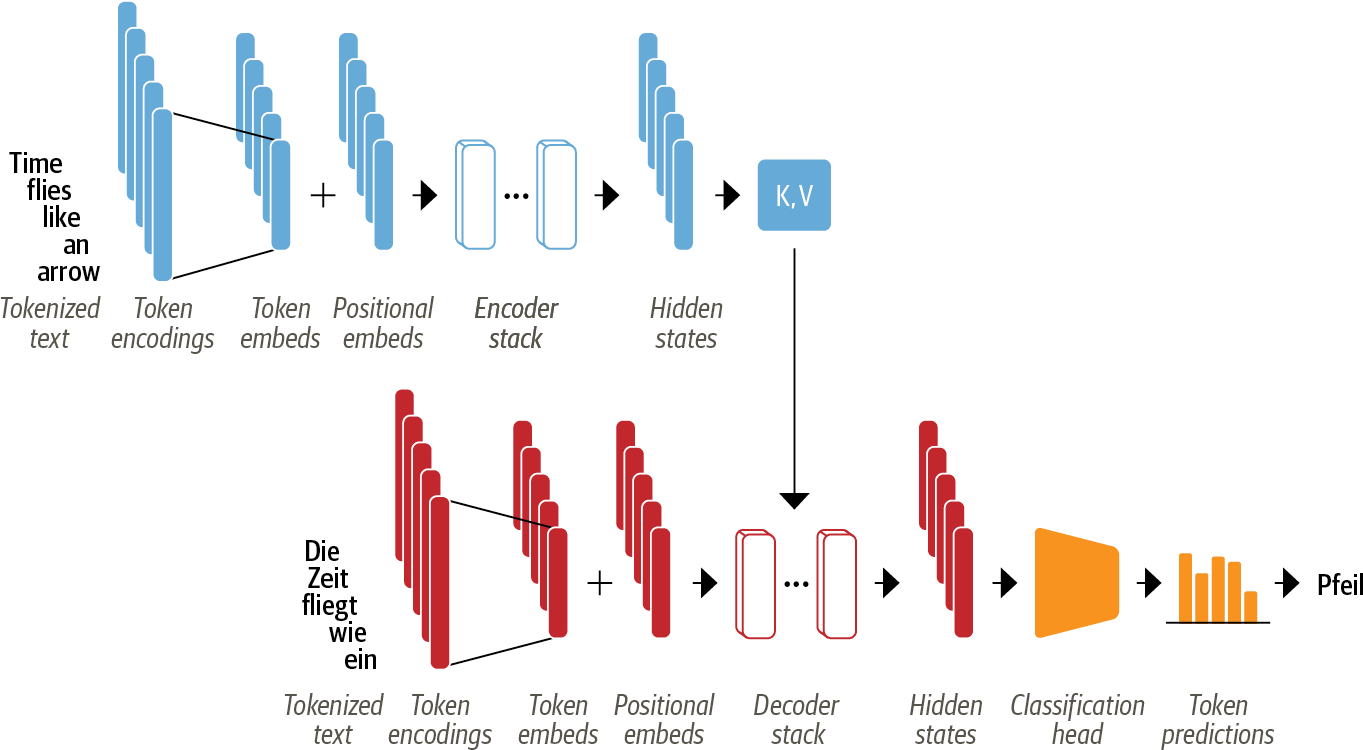

Transformer的结构如下：
* 与第二章聚到的一样我们首先把输入的文本分词转化为token embeddings， 但是attention机制没有注意到与token位置相关的信息，所以我们需要positional embeddings
* encoder由一系列encoder层组成，类似于计算机视觉中的卷积层。同样的，decoder也有他自己的一系列的decoder层
* encoder的输出呗反馈到decoder的每个层，decoder生成对序列下一个token的预测。这一输出会反馈给decoder来输出下一个token，直到预测end-of-sequence(EOS) token。

> 虽然transformer结构最早是被用于解决像是机器翻译等sequence-to-sequence任务，但是encoder和decoder模块很快做出调整变为独立的模型

**Transformer 模型的三大类别**  
1. Encoder-only  
    这类模型经常是将输入序列转化为数量表征以适应像是文本分类或者命名实体识别这样的任务。`BERT及其变种，如RoBERTa和DistilBERT`都属于这一类结构。
    > 因为这一类结构计算某一个token的表征时经常是考虑到这个token前后的上下文，所以也经常被叫做`bidirectional attention`
2. Decoder-only  
    当被提供提示文本如“Thanks for lunchm I had a ...”时这些模型会产生一个序列来完成对接下来最可能出现的词的预测。`GPT家族则属于这个类别`。
    > 因为这一架构中对于给定token的表征计算只取决于左侧上下文，他们也常被称作`causal或者autoregressive attention`
3. Encoder-decoder  
    这一类型的模型被用于复杂匹配（map），即从一个序列的文本去匹配另一个。他们适用于机器翻译和总结任务（summarization task）。`BART和T5模型`属于这一类别


# The Encoder
每个encoder层接收一个embedding序列并将他们反馈给以下的子层：
1. A multi-head self-attention layer
2. A fully connected feed-forward layer that is applied to each input embedding  

The output embedding of each encoder layer have the same size as the inputs. encoder stack的主要作用就是为embedding编入更多序列内上下文的信息到它的表示中。 结构详情见下图
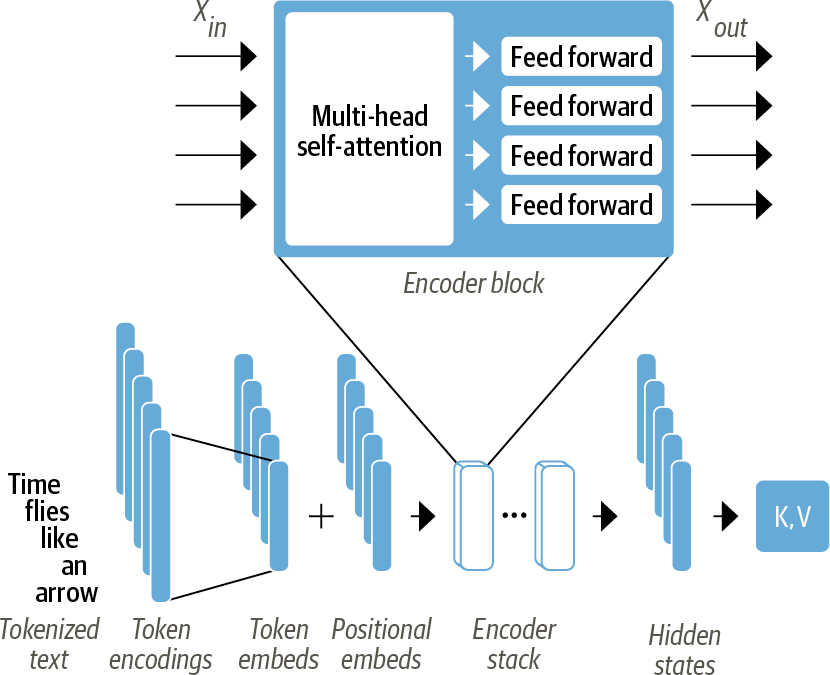

## Self-Attention
主要思路：与其对每个token用固定的embedding，我们可以用整个序列去计算每个embedding的加权平均。换句话说，给到一系列token embedding $x_1, ..., x_n$， sel-attention生成一个新的embedding序列$x'_1,...,x'_n$, 每个$x'_i$都是$x_j$的线性组合：

$x'_i = \sum_{j=1}^n w_{ji}x_j$  
系数$w_{ji}$就是所谓attention weights，且 $∑_jw_{ji} = 1$。同时这种结合上下文做embedding的方式被称作contextualized embeddings 

下图展示了self-attention怎样把原始的token embedding转化为contextualized embedding。这里举例“flies”代表动词和名词不同的语境下是如何被识别的
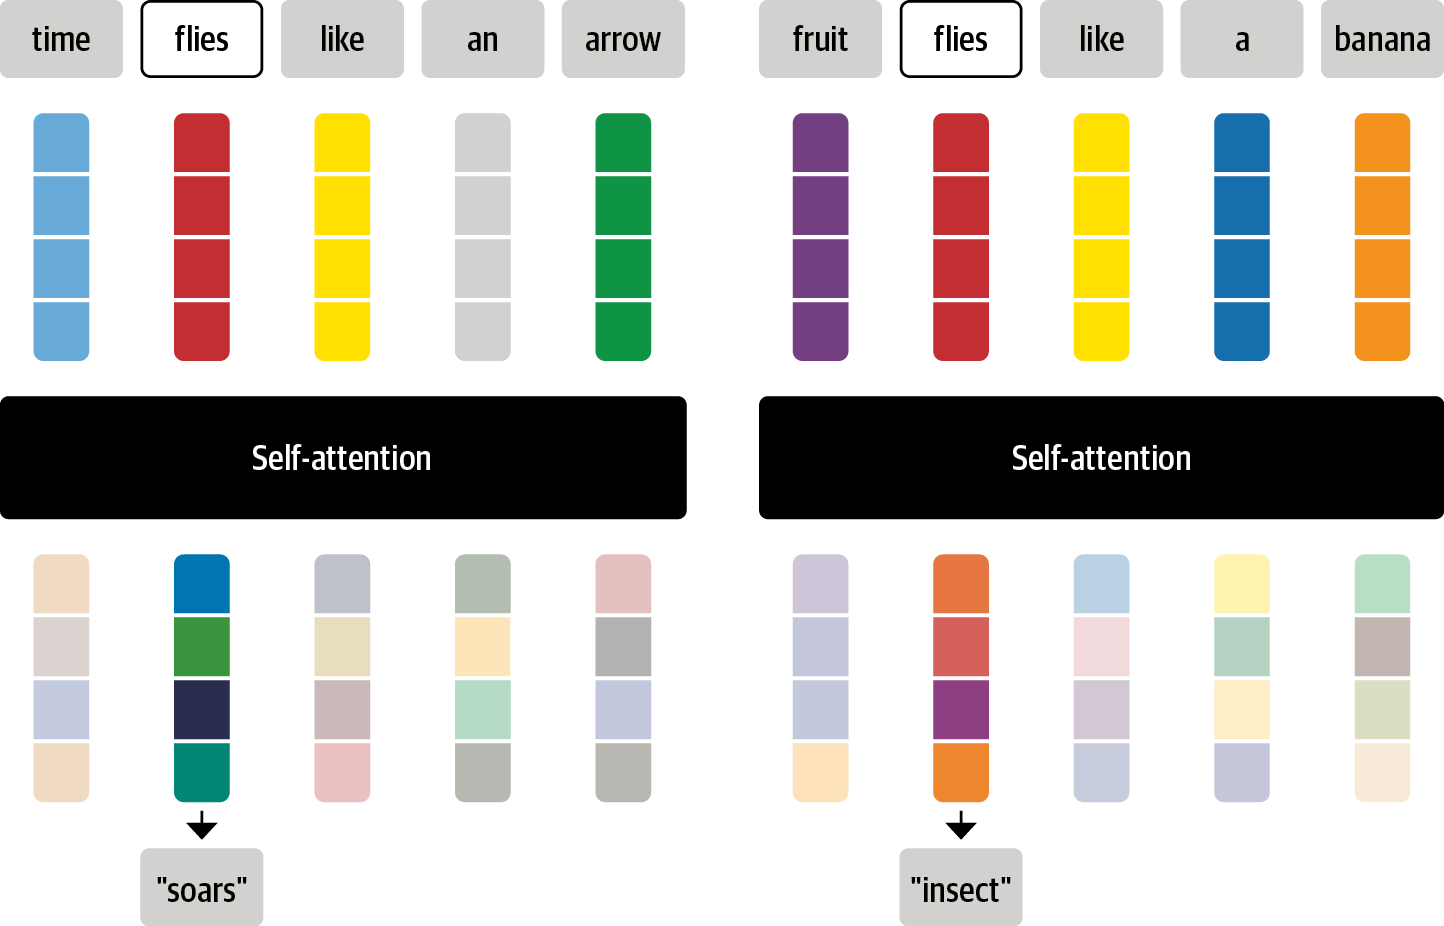

### Scaled dot-product attention
最常用的实现self-attention layer的方法，步骤如下：
1. 将token embedding投影到三个向量*query,key,value*
2. 计算attention分数。利用相似性函数来计算query和key向量在多大程度上是相关的。相似性函数是利用矩阵乘法计算embeeding，当点乘结果大时query和key的相似度就高，反之则相似性差或不相似。这一步得到的输出是attention scores
3. 计算attention weights。点积通常可以产生任意大的数字，这会破坏训练过程的稳定性。 为了解决这个问题，attention scores首先乘以一个比例因子以归一化它们的方差，然后用 softmax 归一化以确保所有列值总和为 1。生成的 n × n 矩阵现在包含所有注意力权重$w_{ji}$。
4. 更新token embedding。将计算好的$w_{ji}$用于更新$x'_i = \sum_{j=1}^n w_{ji}x_j$ 

**可视化attention weight计算过程**  
利用`BertViz for Jupyter`库。我们可利用这个库的neuron_view模块来可视化attention weights来看query和key向量怎样结合得到最终的权重

In [1]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode = "light", layer=0, head=8)

2023-03-11 15:30:37.745011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

本章结构由Pytorch完成（因为我比较习惯用TensorFlow，所以结尾用TensorFlow又写一遍Transformer。)实现的细节如下
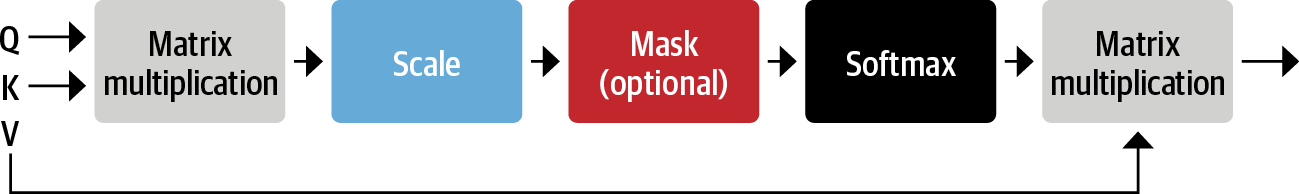

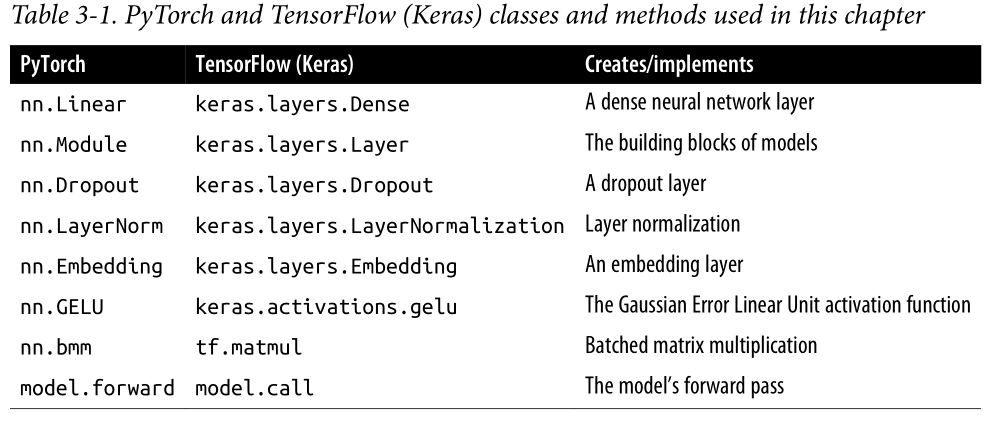

In [2]:
inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False)
#这里add_special_tokens=False将[CLS],[SEP]等特殊符号删除
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

下一步我们要对分词做dense embedding，这里的dense指embedding中不包含0数值

In [3]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

这里面是导入与bert-base-uncased checkpoint。transformers中每个checkpoint被放置到一个配置文件中，其中设置了很多超参数如vocab_size和hidden_size。在我们的示例中，它向我们展示了每个输入 ID 将映射到存储在 nn.Embedding 中的 30,522 个embedding向量之一，每个向量的大小为 768。

现在的embedding还不包含上下文信息，也就是说“fly”代表苍蝇或者飞翔的意思都是一样的表示，接下来的attention层作用是混合这些标记嵌入，以消除歧义并告知每个标记的表示及其上下文的内容。

In [4]:
#输入token生成dense embedding
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()
#[batch_size, seq_len, hidden_dim]即是embedding的数据形式

torch.Size([1, 5, 768])

In [5]:
#接下来我们在进行position encoding之前要创建query，key和value向量来计算attention score
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

这里注意，实际上的query、key和value向量是通过对token embedding乘上对应的权重$W_{Q,K,V}$来求得的，但是为简化起见用相同向量代替（下一小节会介绍如何分开投影）。
> torch.bmm()函数即batch matrix-matrix，可以用于简化计算具有同样shape的query和key向量[batch_sze, seq_len, hidden_dim]。当然如果没有batch size这一维度可以简单用矩阵相乘即可

In [6]:
#通过softmax函数
import torch.nn.functional as F 

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)


tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [7]:
#让attention weight乘上values
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [8]:
#将以上步骤封装到函数中
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)


在此我们可以看到如果query和key向量上下文相同时会计算得非常大分数，尤其是当同一个单词本身时（点乘本身时会得1）。但是在实践中，相较于这个词本身，一个词的含义主要从它上下文的补充词所推断出来的。因此下一节我们要介绍一下将token embedding分别线性投影到三个不同的线性空间上以得出得到query，key和value。

### Multi-headed attention 

实践中将token embedding做线性变换到三个不同向量，这些线性变换即是对embedding的投影，每个投影都带有自己的一组可学习参数，这使得自注意力层可以专注于序列的不同语义方面。  
事实证明，拥有多组线性投影是有帮助的，每组representing所谓的*attention head*。下图可见*multi-head attention layer*的结构。
* 我们需要多个attention head的原因是什么呢？  
每个head的softmax函数倾向于某一方面的相似度。因此多个head可以同时关注到多个方面。例如，一个head可以关注到主谓互动，而另一个可以关注到附近的形容词。当然我们不是手动将这些关系添加到模型中，它们完全是从数据中心学习的。这与计算机视觉卷积神经网络多个卷积核（过滤器/特征映射）的工作原理类似

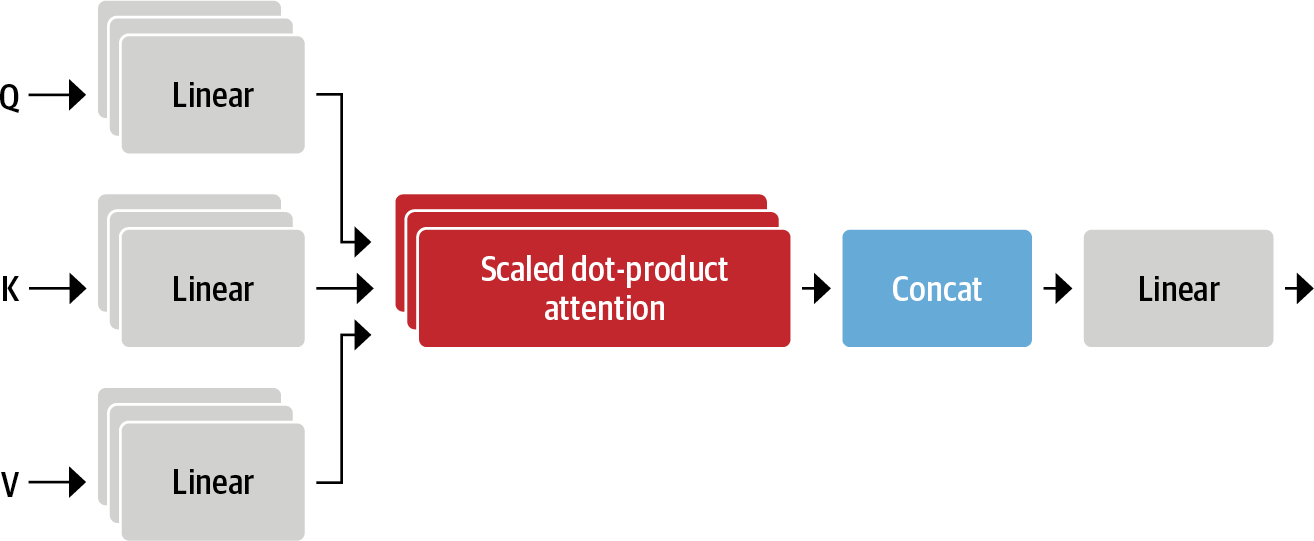

In [10]:
#实现一个attention head

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

head_dim是投影到的空间数目，虽然head_dim没必要一定小于token embedding的维度，但在实践中我们通常选择可以整除embed_dim的数，以保证每个head的计算结果是恒定的。例如，BERT有12个attention head， 所以每个head的维度是768/12 = 64

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim = -1)
        x = self.output_linear(x)
        return x


In [18]:
#在初始化 MultiHeadAttention 模块时，我们传递了之前从预训练 BERT 模型加载的配置。 这确保我们使用与 BERT 相同的设置
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

In [12]:
#再次使用BertViz来可视化attention对两个不同意思的“flies”的学习过程。
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions = True)

sentence_a = 'time flies like an arrow'
sentence_b = 'fruit flies like a banana'

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors = 'pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

上图所示，线的粗细代表了attention权重，深线代表value接近于1，浅线代表value接近于0。注意看两个句子“flies”的attention 权重最大的分别是“arrow”和“Banana，fruit”，也即BERT是以此识别动词和名词的。


## The Feed-Forward Layer
encoder layer 缺失的部分：`position-wise feed-forward networks. `
feed-forward sublayer是encoder和decoder简单的全连接神经网络，但是它做出了一些改变：没有将整个序列的embedding转变为一个向量，取而代之的是对每个embedding一一映射。也是因为这个原因，这层也被叫做*position-wise feed-forward networks.*。
> 值得一提的是在计算机视觉领域有一个类似功能的组件，一个大小为1的卷积核，通常被称为一维卷积（Open AI的GPT代码库选择用这种命名方法）  

文献中的经验法则是**第一层的隐藏大小是嵌入大小的四倍，最常用的是 GELU 激活函数**。 这是假设发生大部分容量和记忆的地方，也是在扩展模型时最常扩展的部分。 我们可以将其实现为一个简单的 nn.Module，如下所示

In [14]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x



请注意，前馈层（如 nn.Linear）通常应用于形状为 (batch_size, input_dim) 的张量，它独立地作用于批量维度的每个元素。 这实际上对于除最后一个维度之外的任何维度都是正确的，所以当我们传递一个形状为 (batch_size, seq_len, hidden_dim) 的张量时，该层将独立应用于 batch 和 sequence 的所有token embedding，这正是我们想要的。 让我们通过传递注意力输出来测试一下

In [15]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

## Adding Layer Normalization
以上我们已经可以完全建立起encoder层了，现在我们只需要考虑下在哪儿skip connections并添加layer normalization。

如前所述，Transformer结构应用了layer normalizatrion以及skip connections。前者保证了每个batch拥有零均值和单位方差。skip connections即是将一个张量直接传递到模型的下一层不做任何处理。当对encoder和decoder层添加layer normalization时，文献中通常采用两个主流的选择：
1. Post layer normalization：
    这是Transformer论文中采用的方法，它将归一化层添加到skip connections之间。注意，这一安排很难从头开始训练，因为梯度可能会发散，为此卖我们经常可以看到一个被称为learning rate warm-up的概念，即是在训练过程中学习率从一个小值逐渐增加到某个最大值。
2. Pre layer normalization：
    这是目前文献中最常见的安排，他们将归一化层放置于skip connections的范围内。这在训练期间往往更加稳定，且通常不需要任何learning rate warm-up。  

具体差别如下图：
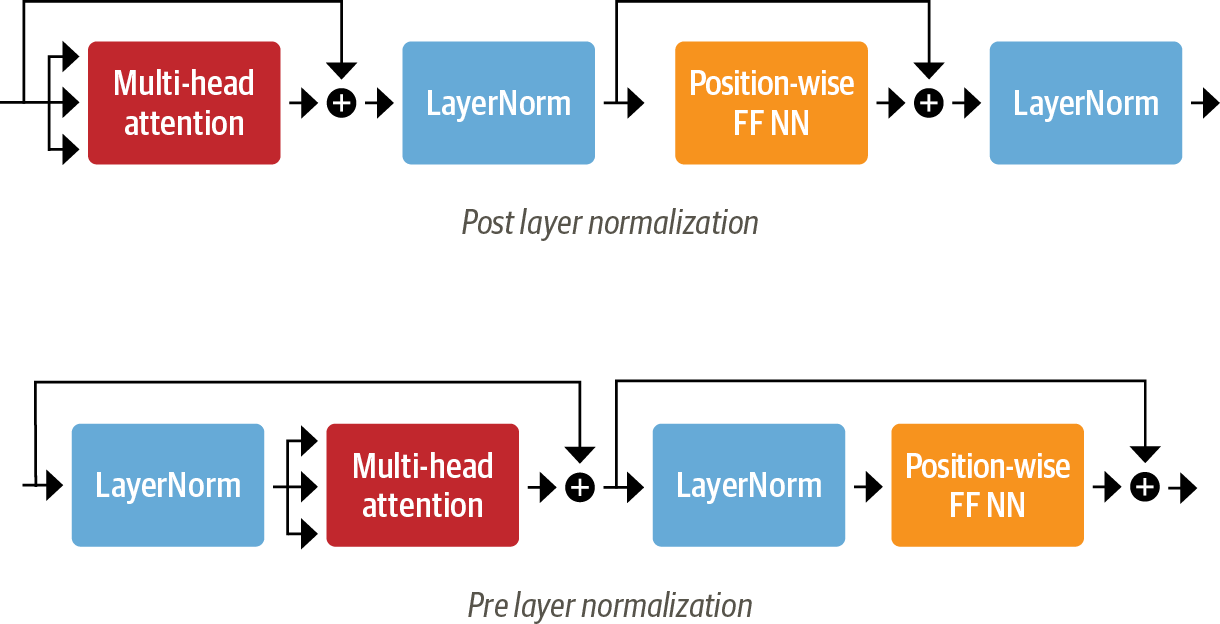
> 根据图中所示between the skip connection即意味着归一化层在单个skip connection之外，skip connections之间；within the span of the skip connection是归一化层放到每个skip connection之内


In [16]:
#我们采用第二种办法，即pre layer normalization的方法来构建我们的组件
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)


    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection(dropout layer)
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [17]:
#利用我们的token embedding输入测试下
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

## Positional Embeddings  
虽然有上述部分我们已经实现了第一个encoder层。但是我们设置encoder层的时候有一个警告：他们对标记的位置完全不变。由于multi-head attention层是一个奇特的加权和*， 因此丢失了位置信息
> *实际上用术语来说，自注意力层和前馈层被称为`置换等变`——如果输入被置换，则该层的相应输出以完全相同的方式置换。  

我们利用Positional Embeddings来弥补这一问题。Positional Embeddings的基本想法是：  
使用包含向量中排列位置信息的pattern来增广token embeddings。如果pattern对于每个位置是独特的话，每个堆栈中的attention heads和feed-forward层可以学习将位置信息合并到转换中。

具体的方法：
1. learnable pattern（最常用方法，尤其在预训练数据足够大的时候）  
    这里采用的方法跟token embeddings完全一致，但是用的是未知索引我不是tokenID作为输入。通过这种方法，可以在预训练期间学习对标记位置进行编码的有效方法。而embedding的结果恰恰就是将token embedding和Positional embedding简单加和即可
> 以下代码我們可以看到embedding层为每一个token建立了一个密集embedding。当然还有一些除了learnable position embedding之外的方法：  
2. *Absolute positional representations*（当没有大量数据可用时，此方法很有效）  
    Transormer模型可以使用有sine和cosine信号组成的静态模式来对token的位置进行编码

3. *Relative positional representations*  
    虽然绝对位置很重要，但是有人会说计算embedding时周围的token才是最重要的。Relative Positional representations遵循该直觉，对token间相对位置进行编码。值得注意的是，在实践过程中没有办法在最开始引入一个新的relative embedding层，因为relative rembedding会跟着我们关注序列中每个token的过程而变化。取而代之的是，注意力机制被新增的附加项锁修改，这些附加项考虑了token之间的相对位置。像DeBERT这种模型就用到了此类表示方法。


In [18]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                             config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
                                                config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps = 1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [19]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [20]:
# 把之前建立好的encoder层放到一起，以建立完整的transformer encoder
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])
        
    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x 

In [29]:
#查看输出的格式
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

根据建立encoder的路径，我们最终从每批的每个token得到了一个hidden state。这一输出形式使得这种结构非常的灵活，我们可以非常简单的将它使用到多种应用中，比如预测被遮住的语言模型中确实的token或者预测问答模型的开始和结束。下面我们来看一下怎样构建一个像chapter2时做的分类器

## Adding a Classification Head

Transformer模型通常会被分为与任务独立的body和专精某项任务的head。第四章我们会再次看到这个模式。我们到此为止在构建的都是body，所以如果我们希望去构建一个文本分类器，我们需要给这个body添加一个分类器的head。我们对每个token都有一个hidden state，但是我们仅仅需要一个预测。传统意义上来说，这类模型的第一个token通常被用来做预测，然后我们可以添加dropout和linear层来做预测。以下代码就是在现存的encoder之上添加的序列分类器

In [22]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x


In [23]:
#初始化模型之前我们需要定义要预测多少类
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

这与我们在第二章用来识别tweets情感分类的BERT模型就很相近了。

# The Decoder

根据下图所示，decoder和encoder最大的不同是它有两个attention sublayers：
* Masked multi-head self-attention layer  
    保证我们每次生成的token仅仅基于过去的输出和现在正在预测的token。没有这一层的话，decoder可以在训练时通过简单复制目标翻译来作弊；屏蔽输入确保任务不是如此简单
* Encoder-decoder attention layer  
    对encoder堆栈的输出key和value向量执行multi-head attention，decoder中间表征作为query。这样encoder-decoder attention 层学习如何将来自两个不同序列的标记相关联，如两种不同的语言。decoder可以访问每块中的encoder keys和values。
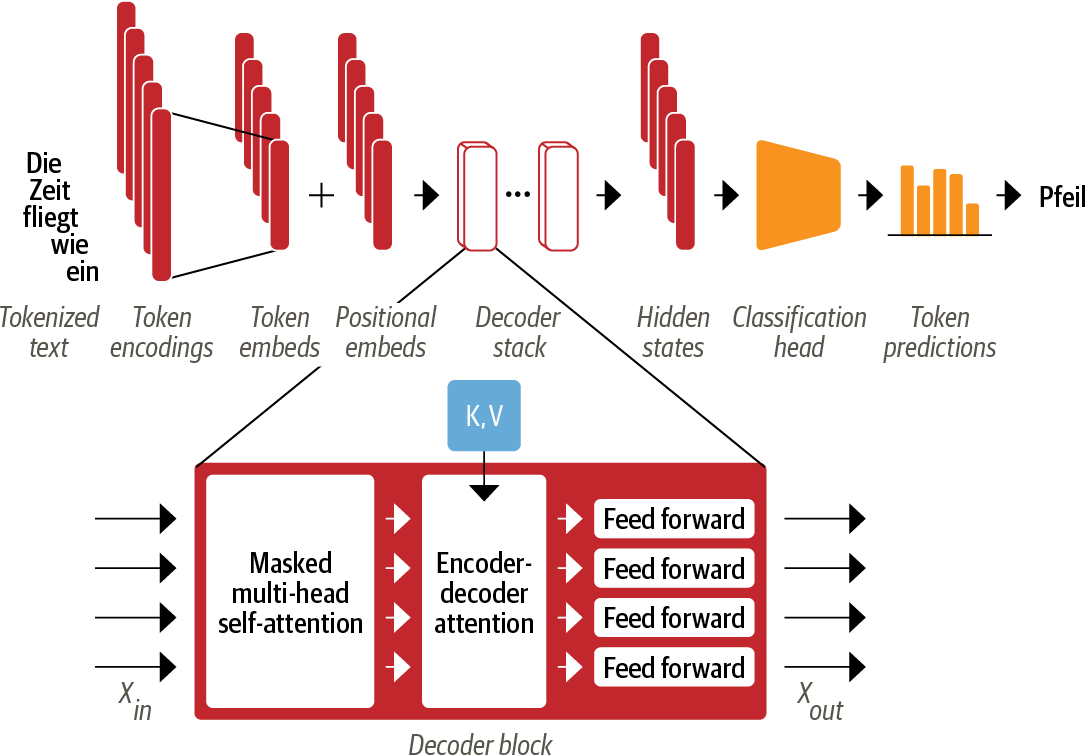

*Mask Matrix*  
masked self-attention的关键诀窍就是mask matrix，即下对角线为1，上方为0的矩阵

In [24]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

tril()函数，就是创建下三角矩阵。当我们有了mask矩阵，我们就可以阻止attention head偷窥未来的tokens，这里我们会用到Tensor.masked_fill()函数来将所有的零替换为负无穷

In [25]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[ 3.0196e+01,        -inf,        -inf,        -inf,        -inf],
         [-1.3085e-01,  2.9907e+01,        -inf,        -inf,        -inf],
         [-2.5546e+00,  6.8382e-01,  2.9648e+01,        -inf,        -inf],
         [ 9.6257e-03,  8.7536e-01,  5.5524e-01,  2.7266e+01,        -inf],
         [ 8.1176e-01,  1.1916e+00,  8.0491e-01, -3.6862e-01,  2.8364e+01]]],
       grad_fn=<MaskedFillBackward0>)

把下三角矩阵的零替换后，我们保证使用softmax计算scores时所有attention weight在为零，因为$e^{-\infty} = 0$。我们可以简单的将之加入到我们scaled dot-product attention函数中

In [26]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2))/sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0 , float("-inf"))
    weights = F.softmax(scores, dim = -1)
    return weights.bmm(value)

以上即是Decoder层的简单内容；这里建议读者去看Andrej Karpathy实现[minGPT](https://github.com/karpathy/minGPT)的细节。
> 注：23年已经更新到[nanoGPT](https://github.com/karpathy/nanoGPT)，是基于GPT-2训练的，利用一个8*A100 40G的节点训练了4天

# Meet the Transformers

**前情提要**：  
在进行比文本分类更高级的任务之前我们先回顾下已经学习过的Transformer知识，这里作者极具想象力的利用一个例子来解释encoder和decoder是如何工作的，原文如下
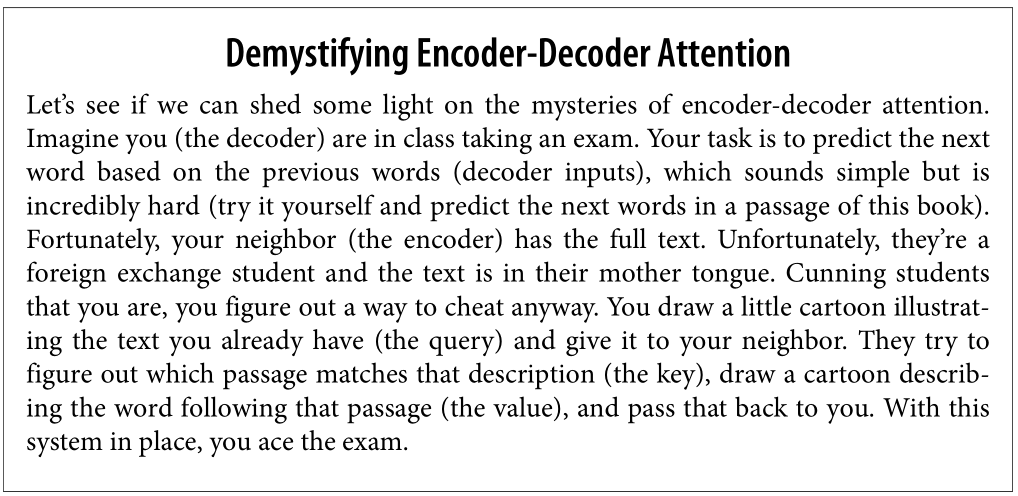


## The Transformer Tree of Life
我们由前文所述，Transformer主要由三种结构：encoder，decoder，encoder-decoder。久而久之这三个主要结构有其各自的进化特点
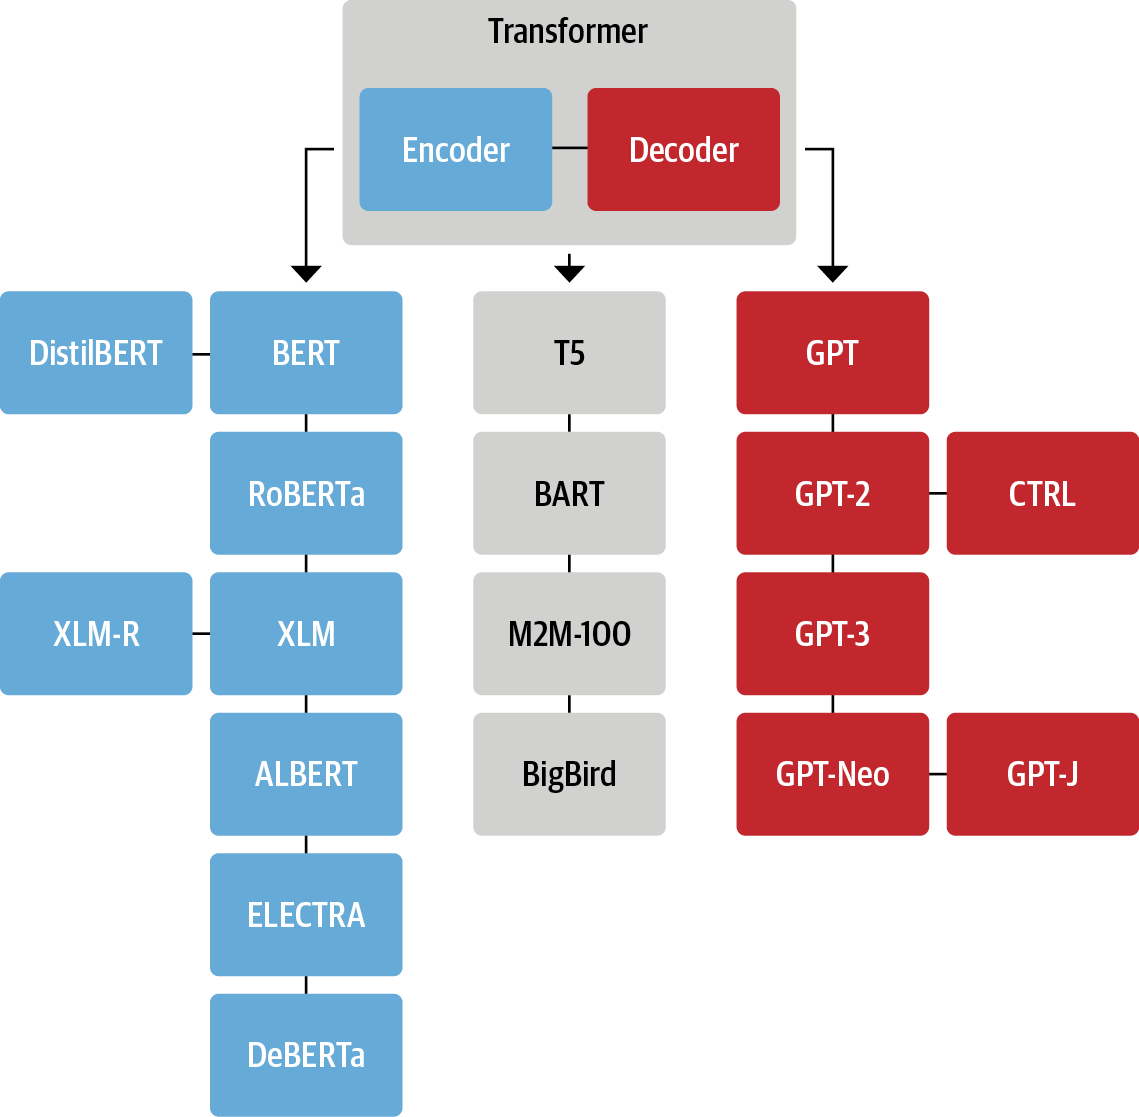


## 报菜名
### The Encoder Branch
在深入了解Transformer的原理之后我们接下来近距离的了解下encoder分支近年来的发展。  
第一个基于Transformer的encoder-only模型是BERT。当它发布的时候，它在所有的GLUE（一个衡量多个不同难度任务的自然语言理解平台）任务中打败了所有基准的SOTA模型。在BERT基础之上的各种模型已经成为了NLU在研究和工业界的主要模型，如文本分类、命名实体识别和问答等。
1. BERT  
    BERT的预训练有两个目标，即预测文本中的masked tokens并确定一个文本段落是否能跟在另一个文本段落之后。前一个任务称为`masked language modeling(MLM)`，而后者是`next sentence prediction(NSP)`
2. DistilBERT  
    尽管BERT的结果很棒，但是它的大小使得在需要低延迟的环境中部署变得棘手。利用知识蒸馏技术，DistilBERT实现了BERT97%的效果，却仅需要40%的内存而且比BERT速度快60%。第八章会更详细的介绍知识蒸馏的内容。
3. RoBERTa  
    在BERT发布后一项研究表明，可以通过修改预训练方案来进一步提升其性能。RoBERTa的训练时间更长，批次更大，训练数据更多，而且它还放弃了NSP任务。结果是这些变化显著提高了BERT的性能
4. XLM  
    在跨语言模型（`cross-lingual language model`, XLM）的工作中探索了构建多语言模型的几个预训练目标，包括来自类GPT的自回归语言模型和来自BERT的MLM。此外，XLM论文的作者介绍了翻译语言模型（`translation language modeling`，TLM）它是MLM对多语言输入的扩展。通过对这些预训练任务的试验，他们在多个多语言NLU基准测试及翻译任务上取得了最先进的结果
5. XLM-RoBERTa  
    继XLM和RoBERTa的工作之后，XLM-RoBERTa（XLM-R）模型通过大规模升级训练数据，使多语言预训练更进一步。他们使用Common Crawl语料库，且开发人员创建了一个包含2.5TB文本的数据集。然后他们在这个数据集上用MLM训练了一个encoder。由于数据集仅包含没有平行文本（也即翻译）的数据，因此放弃了XLM的TLM目标。这种方法大大击败了XLM和多语言BERT变体，尤其是在低资源语言上
6. ALBERT  
    ALBERT模型引入了三个变化使得encoder结构更加高效。  
    1. 它将token embedding维度与隐藏维度分离，从而允许embedding维度较小，以节省参数，尤其是在词汇量变大时。  
    2. 所有层共享相同的参数，这进一步减少了有效参数的数量。  
    3. NSP目标被句子顺序预测所取代：模型需要预测两个连续句子的顺序是否被交换，而不是预测它们是否属于一起。  
    这些变化使得用更少的参数更大的模型成为可能，而且在NLU任务上达到卓越的性能。
7. ELECTRA  
    标准MLM与训练目标的一个局限就是在每一个训练步骤只有Masked token的表征被更新了，而其他的输入token则没有。为了解决这个问题，ELECTA使用了双模型方法：  
    1. 第一个模型（非常小）像标准的MLM模型一样工作，预测masked token  
    2. 第二个模型被称为`discriminator`，被赋予了另一个任务，即预测第一个模型的输出中哪些最初是masked。因此Discriminator需要对每一个token做二分类问题，这让训练过程的效率提高了30倍。对于下游任务，discriminator会像标准的BERT一样进行微调
8. DeBERTa  
    DeBERTa模型介绍了两个结构上的变化：  
    1. 每个token都被表征为两个向量：一个针对内容，另一个针对相对位置。通过将token的内容从他们的相对位置分离出来，self-attention层可以更好的模拟附近token对的依赖性。
    2. 在token decoding head中，一个absolute position embedding被添加在softmax层之前。因为每个词的绝对位置也很重要，对decoding尤为如此。DeBERTa是第一个在SuperGLUE基准上打败人类基线的模型(2020年)
> SuperGLUE是一个比GLUE更难的版本，有几个用于衡量NLU性能的子任务组成

### The Decoder Branch
这一类模型主要由OpenAI引领。这一类型的模型尤其擅长对一个序列接下来的词进行预测而且他们经常被用于文本生成任务。

1. GPT & GPT-2
    GPT实际上结合了NLP领域两个主要的想法：  高效的transformer decoder结构，以及迁移学习。这一模型在BookCorpus上训练并且在子任务如分类任务上有很好的结果。（2018）在2019年在训练数据集以及模型大小上做出了提升，形成GPT-2，其可以生产长文本并且上下文致
2. GPT-3  
    延续GPT到GPT-2升级的成功经验，GPT-2升级到GPT-3并且将模型扩大100倍，拥有1750亿个参数。除了能够生成更逼真的文章之外，模型还展现出小样本学习能力：给模型几个某新任务的简单样例，例如转变文本成为代码，模型可以在新例子上完成任务。目前OpenAI没有公开模型，但是可以通过调用[GPT-3](https://oreil.ly/SEGRW)来调用模型，目前ChatGPT也可以使用API调用[ChatGPT](https://openai.com/blog/introducing-chatgpt-and-whisper-apis)，以及[调用指南](https://platform.openai.com/docs/guides/chat)
3. LLAMA  
    Facebook AI lab在2023年2月公布了一个可以用更小的模型[LLaMa](https://github.com/facebookresearch/llama)媲美大模型的效果，宣称7B的模型就可以达到GPT-3的效果，主要是它的代码和模型参数权重对学术界公开，但是这个模型不是专门用于做chat的，可以用few-shot方式或者在instruction dataset多做一些训练来达到让模型可以聊天的目的。当然也有人在添加RLHF后将之训练成[ChatLLaMA](https://github.com/nebuly-ai/nebullvm/tree/main/apps/accelerate/chatllama)


### The Encoder-Decoder Branch
即便现在建模时通常只使用单一的encoder或decoder，还是有一些基于Transformer结构的encoder-decoder变种模型可以在NLU和NLG领域有很好的的应用的：
1. T5   
    T5模型将所有的NLU和NLG任务都统一转化为text-to-text任务。所有的任务都统一为sequence-to-sequence任务。举例来说，对于文本分类任务，这就意味着文本被作为encoder输入，label作为decoder的输出而不仅仅是一个类别。我们会在第6章详细说明。该模型有110亿参数，并且用crawled C4数据集训练。
2. BART  
    BART结合了BERT和GPT将他们融合到encoder-decoder的结构中。
3. M2M-100
4. BigBird


**私货环节**  
以上预训练模型Hugging Face Hub全都有，而且可以利用Transformers来进行微调
